# Import necessary depencencies

In [5]:
!pip install text_normalizer==0.1.3
!pip install HTMLParser==0.0.2

!wget https://raw.githubusercontent.com/dipanjanS/practical-machine-learning-with-python/master/notebooks/Ch07_Analyzing_Movie_Reviews_Sentiment/model_evaluation_utils.py

--2024-12-14 01:55:31--  https://raw.githubusercontent.com/dipanjanS/practical-machine-learning-with-python/master/notebooks/Ch07_Analyzing_Movie_Reviews_Sentiment/model_evaluation_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8575 (8.4K) [text/plain]
Saving to: ‘model_evaluation_utils.py’

model_evaluation_ut 100%[===================>]   8.37K  --.-KB/s    in 0s      

2024-12-14 01:55:31 (51.9 MB/s) - ‘model_evaluation_utils.py’ saved [8575/8575]



In [1]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import text_normalizer as tn
import model_evaluation_utils as meu

np.set_printoptions(precision=2, linewidth=80)

# Load and normalize data

In [27]:
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
import html.parser
import unicodedata
import spacy
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.tokenize.toktok import ToktokTokenizer
nlp = spacy.load("en_core_web_sm")
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True,
                     text_lemmatization=True, special_char_removal=True,
                     stopword_removal=True):

    normalized_corpus = []

    for doc in corpus:

        if html_stripping:
            doc = strip_html_tags(doc)

        if accented_char_removal:
            doc = remove_accented_chars(doc)

        if contraction_expansion:
            doc = expand_contractions(doc)

        if text_lower_case:
            doc = doc.lower()

        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)

        if text_lemmatization:
            doc = lemmatize_text(doc)

        if special_char_removal:
            doc = remove_special_characters(doc)

        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)

        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)

        normalized_corpus.append(doc)

    return normalized_corpus

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
def remove_special_characters(text):
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
# # Cleaning Text - strip HTML
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
import html.parser
dataset = pd.read_csv(r'/content/drive/MyDrive/ColabNotebooks/ml_1002/movie_reviews.csv')

# take a peek at the data
print(dataset.head())
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])

# build train and test datasets
train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

# normalize datasets
norm_train_reviews = normalize_corpus(train_reviews)
norm_test_reviews = normalize_corpus(test_reviews)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


NameError: name 'remove_accented_chars' is not defined

# Tokenize train & test datasets

In [9]:
tokenized_train = [tn.tokenizer.tokenize(text) for text in norm_train_reviews]
tokenized_test = [tn.tokenizer.tokenize(text) for text in norm_test_reviews]

NameError: name 'norm_train_reviews' is not defined

# Build Vocabulary Mapping (word to index)

In [6]:
from collections import Counter

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_train for token in review])
vocab_map = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index = np.max(list(vocab_map.values()))
vocab_map['PAD_INDEX'] = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1
vocab_size = len(vocab_map)
# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())[10:20]))

NameError: name 'tokenized_train' is not defined

# Encode and Pad datasets & Encode prediction class labels

In [8]:
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# get max length of train corpus and initialize label encoder
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0
max_len = np.max([len(review) for review in tokenized_train])

## Train reviews data corpus
# Convert tokenized text reviews to numeric vectors
train_X = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_train]
train_X = sequence.pad_sequences(train_X, maxlen=max_len) # pad
## Train prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
train_y = le.fit_transform(train_sentiments)

## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
test_X = [[vocab_map[token] if vocab_map.get(token) else vocab_map['NOT_FOUND_INDEX']
           for token in tokenized_review]
              for tokenized_review in tokenized_test]
test_X = sequence.pad_sequences(test_X, maxlen=max_len)
## Test prediction class labels
# Convert text sentiment labels (negative\positive) to binary encodings (0/1)
test_y = le.transform(test_sentiments)

# view vector shapes
print('Max length of train review vectors:', max_len)
print('Train review vectors shape:', train_X.shape, ' Test review vectors shape:', test_X.shape)

NameError: name 'tokenized_train' is not defined

# Build the LSTM Model Architecture

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

NameError: name 'vocab_size' is not defined

In [ ]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1442, 128)         10541824  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 1442, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 10,591,297
Trainable params: 10,591,297
Non-trainable params: 0
_________________________________________________________________
None


# Visualize model architecture

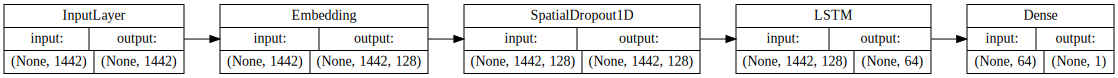

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False,
                 rankdir='LR').create(prog='dot', format='svg'))

# Train the model

In [ ]:
batch_size = 100
model.fit(train_X, train_y, epochs=5, batch_size=batch_size,
          shuffle=True, validation_split=0.1, verbose=1)

Train on 31500 samples, validate on 3500 samples
Epoch 1/5
31500/31500 [==============================] - 2491s - loss: 0.4081 - acc: 0.8184 - val_loss: 0.3006 - val_acc: 0.8751
Epoch 2/5
31500/31500 [==============================] - 2489s - loss: 0.2253 - acc: 0.9158 - val_loss: 0.3209 - val_acc: 0.8780
Epoch 3/5
31500/31500 [==============================] - 2656s - loss: 0.1431 - acc: 0.9493 - val_loss: 0.3483 - val_acc: 0.8671
Epoch 4/5
31500/31500 [==============================] - 2604s - loss: 0.1023 - acc: 0.9658 - val_loss: 0.3803 - val_acc: 0.8729
Epoch 5/5
31500/31500 [==============================] - 2701s - loss: 0.0694 - acc: 0.9761 - val_loss: 0.4430 - val_acc: 0.8706


# Predict and Evaluate Model Performance

In [ ]:
pred_test = model.predict_classes(test_X)
predictions = le.inverse_transform(pred_test.flatten())

15000/15000 [==============================] - 352s   


In [ ]:
meu.display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions,
                                      classes=['positive', 'negative'])

Model Performance metrics:
------------------------------
Accuracy: 0.88
Precision: 0.88
Recall: 0.88
F1 Score: 0.88

Model Classification report:
------------------------------
             precision    recall  f1-score   support

   positive       0.87      0.88      0.88      7510
   negative       0.88      0.87      0.88      7490

avg / total       0.88      0.88      0.88     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   positive negative
Actual: positive       6633      877
        negative        972     6518
